In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
scores = pd.read_csv("train_scores.csv")
train = pd.read_csv("train_logs.csv")
train["activity2"] = train['activity'].apply(lambda row: 'Move' if 'Move' in row else row)

In [3]:
train.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count,activity2
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0,Nonproduction
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0,Nonproduction
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0,Nonproduction
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1,Input
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1,Input


In [69]:
def final_word_count(df):
    return df.iloc[-1]['word_count']

def add_features(df):
    df["unsurity"] = ((df['text_change'].str.len() > 50) & (df['activity2']=="Remove/Cut")).apply(lambda x: int(x))
    df["structural_change"] = ((df['text_change'].str.len() > 50) & (df['activity2']=="Replace")).apply(lambda x: int(x))
    df["long_paste"] = ((df['text_change'].str.len() > 50) & (df['activity2']=="Paste")).apply(lambda x: int(x))
    df["unproductive_time"] = (train['activity2'] == "Nonproduction")*train['action_time']
    df["external_help"] = ((df['word_count'] < 10) & (df['activity2']=="Paste")).apply(lambda x: int(x))
    df["pasted_words_number"] = (train['activity2'] == "Paste")*train['text_change'].str.split().apply(len)
    df["large_changes"] = (df['text_change'].str.len() > 50).apply(lambda x: int(x))
    return df




In [73]:
def drop_unrelated_features(df, feat):
    df = df.drop(feat, axis = 1)
    return df

In [ ]:
grouped_data = train.groupby(['id', "up_event"])
down = grouped_data["event_id"].count()
pivot = pd.pivot_table(data = down.reset_index(), index = "id", columns = "up_event", values = "event_id" ).fillna(0)
pivot

In [70]:
train = add_features(train)
train.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count,activity2,unsurity,structural_change,long_paste,unproductive_time,external_help,pasted_words_number,large_changes
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0,Nonproduction,0,0,0,31,0,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0,Nonproduction,0,0,0,404,0,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0,Nonproduction,0,0,0,0,0,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1,Input,0,0,0,0,0,0,0
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1,Input,0,0,0,0,0,0,0


In [74]:
to_drop = ["down_time","up_time", "activity", "down_event","text_change","cursor_position"]
train = drop_unrelated_features(train,to_drop)

,id,event_id,action_time,up_event,text_change,cursor_position,word_count,activity2,unsurity,structural_change,long_paste,unproductive_time,external_help,pasted_words_number,large_changes
0,001519c8,1,31,Leftclick,NoChange,0,0,Nonproduction,0,0,0,31,0,0,0
1,001519c8,2,404,Leftclick,NoChange,0,0,Nonproduction,0,0,0,404,0,0,0
2,001519c8,3,0,Shift,NoChange,0,0,Nonproduction,0,0,0,0,0,0,0
3,001519c8,4,91,q,q,1,1,Input,0,0,0,0,0,0,0
4,001519c8,5,127,q,q,2,1,Input,0,0,0,0,0,0,0


In [81]:
grouped_data = train.groupby('id')
user = grouped_data.apply(lambda df: pd.Series({
    'Final Word Count': final_word_count(df)
}))

In [83]:
user.head()

,Final Word Count
id,
001519c8,255
0022f953,320
0042269b,404
0059420b,206
0075873a,252


In [84]:
train.head()

,id,event_id,action_time,up_event,word_count,activity2,unsurity,structural_change,long_paste,unproductive_time,external_help,pasted_words_number,large_changes
0,001519c8,1,31,Leftclick,0,Nonproduction,0,0,0,31,0,0,0
1,001519c8,2,404,Leftclick,0,Nonproduction,0,0,0,404,0,0,0
2,001519c8,3,0,Shift,0,Nonproduction,0,0,0,0,0,0,0
3,001519c8,4,91,q,1,Input,0,0,0,0,0,0,0
4,001519c8,5,127,q,1,Input,0,0,0,0,0,0,0


In [9]:
pd.get_dummies()

In [86]:
one_hot_encoded = pd.get_dummies(train['activity2'], prefix='activity').astype(int)

# Concatenate the one-hot encoded columns with the original DataFrame

one_hot_encoded

,activity_Input,activity_Move,activity_Nonproduction,activity_Paste,activity_Remove/Cut,activity_Replace
0,0,0,1,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0
...,...,...,...,...,...,...
8405893,0,0,1,0,0,0
8405894,0,0,1,0,0,0
8405895,0,0,0,0,0,1
8405896,0,0,1,0,0,0


In [87]:
train = pd.concat([train, one_hot_encoded], axis=1)


,id,event_id,action_time,up_event,word_count,activity2,unsurity,structural_change,long_paste,unproductive_time,external_help,pasted_words_number,large_changes,activity_Input,activity_Move,activity_Nonproduction,activity_Paste,activity_Remove/Cut,activity_Replace
0,001519c8,1,31,Leftclick,0,Nonproduction,0,0,0,31,0,0,0,0,0,1,0,0,0
1,001519c8,2,404,Leftclick,0,Nonproduction,0,0,0,404,0,0,0,0,0,1,0,0,0
2,001519c8,3,0,Shift,0,Nonproduction,0,0,0,0,0,0,0,0,0,1,0,0,0
3,001519c8,4,91,q,1,Input,0,0,0,0,0,0,0,1,0,0,0,0,0
4,001519c8,5,127,q,1,Input,0,0,0,0,0,0,0,1,0,0,0,0,0


In [88]:
train = train.drop("activity2", axis = 1)
train.head()

,id,event_id,action_time,up_event,word_count,unsurity,structural_change,long_paste,unproductive_time,external_help,pasted_words_number,large_changes,activity_Input,activity_Move,activity_Nonproduction,activity_Paste,activity_Remove/Cut,activity_Replace
0,001519c8,1,31,Leftclick,0,0,0,0,31,0,0,0,0,0,1,0,0,0
1,001519c8,2,404,Leftclick,0,0,0,0,404,0,0,0,0,0,1,0,0,0
2,001519c8,3,0,Shift,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,001519c8,4,91,q,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,001519c8,5,127,q,1,0,0,0,0,0,0,0,1,0,0,0,0,0


In [90]:
train = train.drop("up_event", axis = 1)
train.head()

,id,event_id,action_time,word_count,unsurity,structural_change,long_paste,unproductive_time,external_help,pasted_words_number,large_changes,activity_Input,activity_Move,activity_Nonproduction,activity_Paste,activity_Remove/Cut,activity_Replace
0,001519c8,1,31,0,0,0,0,31,0,0,0,0,0,1,0,0,0
1,001519c8,2,404,0,0,0,0,404,0,0,0,0,0,1,0,0,0
2,001519c8,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,001519c8,4,91,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,001519c8,5,127,1,0,0,0,0,0,0,0,1,0,0,0,0,0


In [92]:
agg_columns = {
    'event_id':'count',
    'action_time': 'sum',
    'unsurity': 'sum',
    'structural_change': 'sum',
    'long_paste': 'sum',
    'unproductive_time': 'sum',
    'external_help': 'sum',
    'pasted_words_number': 'sum',
    'large_changes': 'sum',
    'activity_Input': 'sum',
    'activity_Move': 'sum',
    'activity_Nonproduction': 'sum',
    'activity_Paste': 'sum',
    'activity_Remove/Cut': 'sum',
    'activity_Replace': 'sum'
}

In [93]:
user_level = train.groupby('id').agg(agg_columns)
user_level.head()

,event_id,action_time,unsurity,structural_change,long_paste,unproductive_time,external_help,pasted_words_number,large_changes,activity_Input,activity_Move,activity_Nonproduction,activity_Paste,activity_Remove/Cut,activity_Replace
id,,,,,,,,,,,,,,,
001519c8,2557,297243,0,0,0,18506,0,0,0,2010,3,120,0,417,7
0022f953,2454,275391,0,0,0,13781,0,0,0,1938,0,254,1,260,1
0042269b,4136,421201,1,4,0,33951,0,0,5,3515,0,175,0,439,7
0059420b,1556,189596,0,0,0,3062,0,1,0,1304,0,99,1,151,1
0075873a,2531,313702,0,0,0,6988,0,0,0,1942,0,72,0,517,0


In [94]:
pivot

up_event,!,"""",#,$,%,&,',(,),*,...,,,¡,¿,Â´,Ä±,Å,Ë,â,ä
id,,,,,,,,,,,,,,,,,,,,,
001519c8,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0022f953,0.0,6.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0042269b,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0059420b,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0075873a,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffb8c745,0.0,4.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ffbef7e5,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ffccd6fd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
merged_data = pd.merge(user_level, pivot, on='id', how='inner')
merged_data.head()

,event_id,action_time,unsurity,structural_change,long_paste,unproductive_time,external_help,pasted_words_number,large_changes,activity_Input,...,,,¡,¿,Â´,Ä±,Å,Ë,â,ä
id,,,,,,,,,,,,,,,,,,,,,
001519c8,2557,297243,0,0,0,18506,0,0,0,2010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0022f953,2454,275391,0,0,0,13781,0,0,0,1938,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0042269b,4136,421201,1,4,0,33951,0,0,5,3515,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0059420b,1556,189596,0,0,0,3062,0,1,0,1304,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0075873a,2531,313702,0,0,0,6988,0,0,0,1942,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
final_merge = pd.merge(merged_data, user, on='id', how='inner')
final_merge.head()

,event_id,action_time,unsurity,structural_change,long_paste,unproductive_time,external_help,pasted_words_number,large_changes,activity_Input,...,,¡,¿,Â´,Ä±,Å,Ë,â,ä,Final Word Count
id,,,,,,,,,,,,,,,,,,,,,
001519c8,2557,297243,0,0,0,18506,0,0,0,2010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255
0022f953,2454,275391,0,0,0,13781,0,0,0,1938,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,320
0042269b,4136,421201,1,4,0,33951,0,0,5,3515,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,404
0059420b,1556,189596,0,0,0,3062,0,1,0,1304,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206
0075873a,2531,313702,0,0,0,6988,0,0,0,1942,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252


In [98]:
final_merge = final_merge.reset_index()
final_merge.head()

,id,event_id,action_time,unsurity,structural_change,long_paste,unproductive_time,external_help,pasted_words_number,large_changes,...,,¡,¿,Â´,Ä±,Å,Ë,â,ä,Final Word Count
0,001519c8,2557,297243,0,0,0,18506,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255
1,0022f953,2454,275391,0,0,0,13781,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,320
2,0042269b,4136,421201,1,4,0,33951,0,0,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,404
3,0059420b,1556,189596,0,0,0,3062,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206
4,0075873a,2531,313702,0,0,0,6988,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252


In [99]:
final_merge.to_csv("train_final.csv", index = None)

In [102]:
final_merge.describe()

,event_id,action_time,unsurity,structural_change,long_paste,unproductive_time,external_help,pasted_words_number,large_changes,activity_Input,...,,¡,¿,Â´,Ä±,Å,Ë,â,ä,Final Word Count
count,2471.000000,2.471000e+03,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000,...,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000
mean,3401.820316,3.336675e+05,0.352084,0.163497,0.102388,17909.078106,0.004856,5.253339,0.628895,2722.297046,...,0.000405,0.000405,0.000809,0.000405,0.004047,0.000405,0.000405,0.001619,0.000405,386.112100
std,1578.850387,1.575202e+05,0.887996,0.536878,0.424501,32568.430834,0.075129,42.045249,1.458841,1196.384644,...,0.020117,0.020117,0.028444,0.020117,0.142220,0.020117,0.020117,0.080468,0.020117,171.773394
min,262.000000,1.345200e+04,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,230.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.000000
25%,2193.500000,2.111480e+05,0.000000,0.000000,0.000000,3993.000000,0.000000,0.000000,0.000000,1786.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,250.000000
50%,3082.000000,3.049510e+05,0.000000,0.000000,0.000000,9308.000000,0.000000,0.000000,0.000000,2477.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,346.000000
75%,4301.000000,4.248140e+05,0.000000,0.000000,0.000000,19685.500000,0.000000,0.000000,1.000000,3397.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,477.000000
max,12876.000000,1.210508e+06,9.000000,6.000000,6.000000,482115.000000,2.000000,1016.000000,17.000000,9091.000000,...,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,4.000000,1.000000,1326.000000


In [109]:
transformed = final_merge.copy()
col = final_merge.columns
transformed[col[1:]] = final_merge[col[1:]].apply(lambda x: x.apply(lambda y: np.log1p(y)))
transformed.head()

,id,event_id,action_time,unsurity,structural_change,long_paste,unproductive_time,external_help,pasted_words_number,large_changes,...,,¡,¿,Â´,Ä±,Å,Ë,â,ä,Final Word Count
0,001519c8,7.846981,12.602309,0.000000,0.000000,0.0,9.825904,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.545177
1,0022f953,7.805882,12.525951,0.000000,0.000000,0.0,9.531119,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.771441
2,0042269b,8.327726,12.950868,0.693147,1.609438,0.0,10.432703,0.0,0.000000,1.791759,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.003887
3,0059420b,7.350516,12.152656,0.000000,0.000000,0.0,8.027150,0.0,0.693147,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.332719
4,0075873a,7.836765,12.656202,0.000000,0.000000,0.0,8.852093,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.533389


In [115]:
transformed.to_csv("transformed.csv")

In [110]:
scores = pd.read_csv("train_scores.csv")
scores.head()

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0


In [112]:
final_v1 = pd.merge(transformed, scores, on='id', how='inner')
final_v1.head()

,id,event_id,action_time,unsurity,structural_change,long_paste,unproductive_time,external_help,pasted_words_number,large_changes,...,¡,¿,Â´,Ä±,Å,Ë,â,ä,Final Word Count,score
0,001519c8,7.846981,12.602309,0.000000,0.000000,0.0,9.825904,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.545177,3.5
1,0022f953,7.805882,12.525951,0.000000,0.000000,0.0,9.531119,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.771441,3.5
2,0042269b,8.327726,12.950868,0.693147,1.609438,0.0,10.432703,0.0,0.000000,1.791759,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.003887,6.0
3,0059420b,7.350516,12.152656,0.000000,0.000000,0.0,8.027150,0.0,0.693147,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.332719,2.0
4,0075873a,7.836765,12.656202,0.000000,0.000000,0.0,8.852093,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.533389,4.0


In [113]:
final_v1.to_csv("Final_v1.csv")

In [114]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class MLP(nn.Module):
    def __init__(self, dx, num_classes):
        super(MLP, self).__init__()
        self.dx = dx
        self.fc1 = nn.Linear(self.dx, 1024)
        # self.fc2 = nn.Linear(20, 20)
        # self.fc3 = nn.Linear(20, 20)
        # self.fc4 = nn.Linear(16, 4)
        self.fc5 = nn.Linear(1024, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = F.relu(self.fc1(x.view(-1, self.dx)))
        # out = F.relu(self.fc2(out))
        # out = F.relu(self.fc3(out))
        # out = F.relu(self.fc4(out))
        out = self.fc5(out)
        out = self.sigmoid(out)
        return out

In [116]:
from sklearn.model_selection import train_test_split

In [117]:
X = transformed.drop(columns=["id"])
y = scores["score"]

# Split the data into training and testing sets (adjust the test_size parameter as needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [120]:
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False, header=True)  # Assuming 'y_train' has column names
y_test.to_csv('y_test.csv', index=False, header=True)  # Assuming 'y_test' has column names

In [126]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [125]:
svc_model = SVC(kernel='rbf', random_state=42)

# Fit the model on the training data
svc_model.fit(X_train, y_train.astype(str))

# Predict on the test data
y_pred = svc_model.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test.astype(str), y_pred)
print(f"Accuracy Score: {accuracy}")

Accuracy Score: 0.28225806451612906


In [161]:
max_acc = -1
for i in range(1,130):
    for j in range(1,30):
        rf_model = RandomForestClassifier(n_estimators=i, max_depth=j, random_state=42)
        # Fit the model on the training data
        rf_model.fit(X_train, y_train.astype(str))

        # Predict on the test data
        y_pred = rf_model.predict(X_test)

        # Calculate the accuracy score
        accuracy = accuracy_score(y_test.astype(str), y_pred)
        if accuracy > max_acc:
            max_acc = accuracy
            n_estimators = i
            depth = j
        # print(f"The n_estimators are: {i} the max depth is {j} Accuracy Score for this is: {accuracy}")

print(f"Best numbers= n_estimators: {n_estimators} | max depth: {depth} | Accuracy Score: {max_acc}")

Best numbers= n_estimators: 87 | max depth: 9 | Accuracy Score: 0.3870967741935484


In [128]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np


In [129]:
regressor = LinearRegression()

# Fit the model on the training data
regressor.fit(X_train, y_train)

# Predict on the test data
y_pred = regressor.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.6387376303984296


In [130]:
feature_importances = rf_model.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame(
    {'Feature': X_train.columns, 'Importance': feature_importances}
)

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importance DataFrame
print("Feature Importance:")
print(feature_importance_df)

Feature Importance:
              Feature  Importance
145  Final Word Count    0.061059
9      activity_Input    0.053286
119                 q    0.049688
91              Space    0.047245
0            event_id    0.044905
..                ...         ...
92                  T    0.000008
69                 F3    0.000007
88                  S    0.000000
142                Ë    0.000000
143               â    0.000000

[146 rows x 2 columns]


In [163]:
rf_model_best = RandomForestClassifier(n_estimators=87, max_depth=9, random_state=42)
# Fit the model on the training data
rf_model_best.fit(X_train, y_train.astype(str))

# Predict on the test data
y_pred = rf_model_best.predict(X_test)

# Calculate the accuracy score
# accuracy = accuracy_score(y_test.astype(str), y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred.astype(float)))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.6956083436402524


In [2]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv') # Assuming 'y_train' has column names
y_test = pd.read_csv('y_test.csv')

In [9]:
class MLPRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLPRegression, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        # You can add more hidden layers if needed
        # self.fc2 = nn.Linear(1024, 512)
        # self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(64, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [6]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

tensor(0.6644)


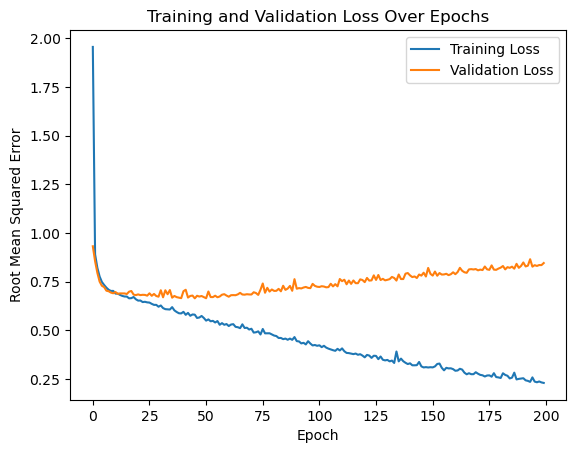

In [41]:
class MLPRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLPRegression, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 64)
        self.fc4 = nn.Linear(64, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Define the model
input_size = X_train.shape[1]  # Update with your input size
output_size = 1  # For regression, output size is typically 1
model = MLPRegression(input_size, output_size)

# Define the loss function (Mean Squared Error for regression)
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # You may need to adjust the learning rate

# Create a DataLoader for batch training
batch_size = 64  # You may need to adjust the batch size
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


val_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

epoch_list = []
training_error = []
validation_error = []

num_epochs = 200  # You may need to adjust the number of epochs
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    epoch_list.append(epoch)
    

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = torch.sqrt(criterion(outputs, targets))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    
    
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            val_loss += torch.sqrt(criterion(outputs, targets))

    average_val_loss = val_loss / len(val_loader)
    
    # print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {average_loss:.4f} | Validation Loss: {average_val_loss:.4f}')
    training_error.append(average_loss)
    validation_error.append(average_val_loss)
    
plt.plot(epoch_list, training_error, label='Training Loss',linestyle='-')
plt.plot(epoch_list, validation_error, label='Validation Loss',linestyle='-')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error')
plt.title('Training and Validation Loss Over Epochs')

# Adding legend
plt.legend()

print(min(validation_error))

# Display the plot
plt.show()
